In [1]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

/home/annie/.local/lib/python2.7/site-packages/librosa/__init__.py:35: FutureWarning: You are using librosa with Python 2. Please note that librosa 0.7 will be the last version to support Python 2, after which it will require Python 3 or later.
  FutureWarning)
Using TensorFlow backend.


## Loading Dataset

Considering only more than 4 sec files and
labelling the files as Normal or Abnormal

TODO: Add artifacts (i.e. noises without heartbeat data) and ask the user to try again

In [2]:
dataset = []
for folder in ["./set_a/**","./set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            duration = librosa.get_duration(filename=filename)
            # skip audio smaller than 3 secs
            if duration>=3:
                slice_size = 3
                iterations = int((duration-slice_size)/(slice_size-1))
                iterations += 1
#                 initial_offset = (duration % slice_size)/2
                initial_offset = (duration - ((iterations*(slice_size-1))+1))/2
                if label not in ["Aunlabelledtest", "Bunlabelledtest", "artifact"]:
                    for i in range(iterations):
                        offset = initial_offset + i*(slice_size-1)
                        if (label == "normal"):
                            dataset.append({
                                "filename": filename,
                                "label": "normal",
                                "offset": offset
                            })
                        else:
                            dataset.append({
                                "filename": filename,
                                "label": "abnormal",
                                "offset": offset
                            })
                        
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1281 entries, 1241 to 1126
Data columns (total 3 columns):
filename    1281 non-null object
label       1281 non-null object
offset      1281 non-null float64
dtypes: float64(1), object(2)
memory usage: 40.0+ KB


TODO: Find a way to use the data with less the 4 seconds

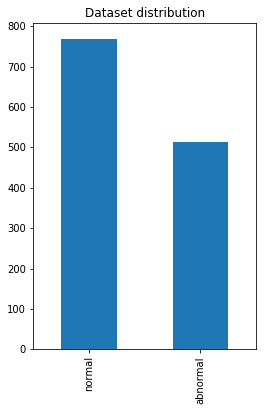

In [3]:
plt.figure(figsize=(4,6))
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

## Split dataset in train and test
80-20 Ratio

In [4]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 1024
Test: 257


## Visualising the data and features

./set_b/normal_noisynormal_140_1306519735121_C.wav
./set_a/murmur__201108222226.wav


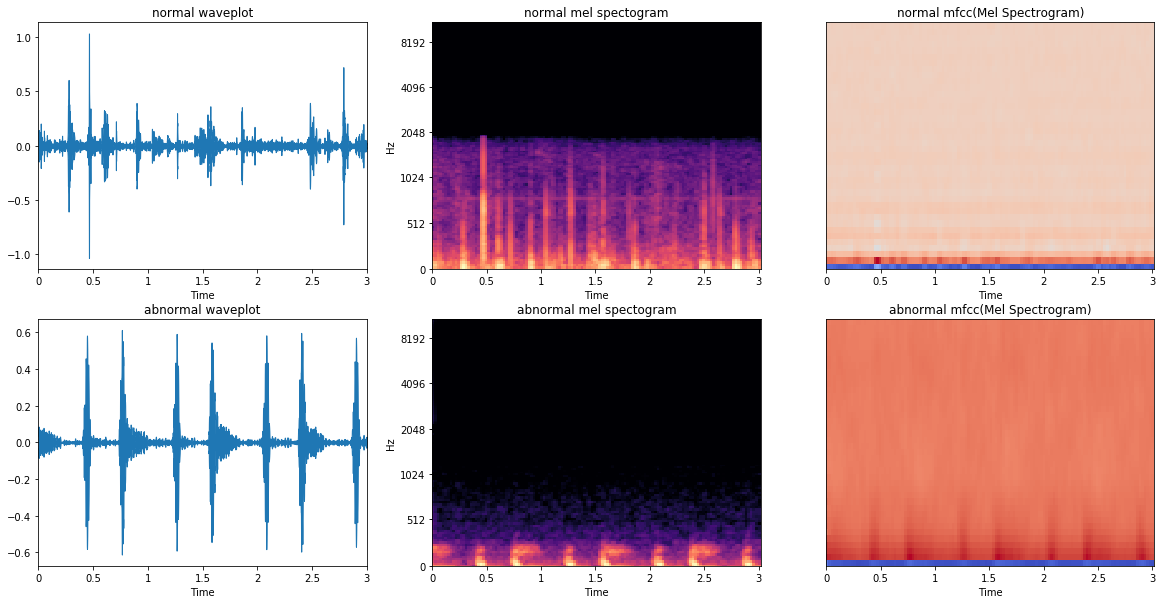

In [5]:
plt.figure(figsize=(20,10))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[33], duration=3)
    print(dataset[dataset.label==label].filename.iloc[33])
    
    # Wave plot
    idx+=1
    plt.subplot(2, 3, idx)
    plt.title("%s waveplot" % label)
    librosa.display.waveplot(y, sr=sr)

    # Mel Spectrogram
    idx+=1
    plt.subplot(2, 3, idx)
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.title("%s mel spectogram" % label)

    # MFCC (Mel spectrogram)
    idx+=1
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)
    plt.subplot(2, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s mfcc(Mel Spectrogram)" % label)
plt.show()

## Extracting features

In [6]:
def extract_features(audio_path,offset):
#     y, sr = librosa.load(audio_path, duration=3)
    y, sr = librosa.load(audio_path, offset=offset, duration=3)
#     y = librosa.util.normalize(y)
    
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, 
                                   hop_length=512, 
                                   n_mels=128)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)

#     mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [7]:
x_train = []
x_test = []

for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx],train.offset.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx],test.offset.iloc[idx]))
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

100%|██████████| 257/257 [00:26<00:00,  9.79it/s]

('X train:', (1024, 40, 130))
('X test:', (257, 40, 130))


In [8]:
## Encode Labels
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

## Input Shapes

In [9]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print("X test:", x_test.shape)
print("Y test:", y_test.shape)


('X train:', (1024, 40, 130, 1))
('Y train:', (1024, 2))
('X test:', (257, 40, 130, 1))
('Y test:', (257, 2))


In [10]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 39, 129, 16)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 64, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 63, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 31, 32)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 31, 32)         0         
_______________________

## Compiling Model

In [11]:
adam = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


Instructions for updating:
keep_dims is deprecated, use keepdims instead



## Fitting Model

In [12]:
%%time
history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=300,
              validation_data=(x_test, y_test),
              class_weight=class_weights,
              shuffle=True)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 1024 samples, validate on 257 samples
Epoch 1/300
1024/1024 [==============================] - 6s 6ms/step - loss: 5.0711 - acc: 0.5430 - val_loss: 1.8990 - val_acc: 0.5953
Epoch 2/300
1024/1024 [==============================] - 5s 5ms/step - loss: 2.9321 - acc: 0.5947 - val_loss: 0.9634 - val_acc: 0.6498
Epoch 3/300
1024/1024 [==============================] - 4s 4ms/step - loss: 1.8816 - acc: 0.5859 - val_loss: 0.7064 - val_acc: 0.6420
Epoch 4/300
1024/1024 [==============================] - 4s 4ms/step - loss: 1.2140 - acc: 0.5830 - val_loss: 0.6632 - val_acc: 0.6304
Epoch 5/300
1024/1024 [==============================] - 4s 4ms/step - loss: 1.0003 - acc: 0.6055 - val_loss: 0.6205 - val_acc: 0.6459
Epoch 6/300
1024/1024 [==============================] - 4s 4ms/s

Epoch 55/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.4810 - acc: 0.7539 - val_loss: 0.5034 - val_acc: 0.7782
Epoch 56/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.4829 - acc: 0.7695 - val_loss: 0.4993 - val_acc: 0.8016
Epoch 57/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.5100 - acc: 0.7520 - val_loss: 0.5029 - val_acc: 0.7665
Epoch 58/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.4820 - acc: 0.7607 - val_loss: 0.5014 - val_acc: 0.7860
Epoch 59/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.4869 - acc: 0.7695 - val_loss: 0.5005 - val_acc: 0.7782
Epoch 60/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.4940 - acc: 0.7568 - val_loss: 0.4961 - val_acc: 0.7743
Epoch 61/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.4888 - acc: 0.7734 - val_loss: 0.4956 - val_acc: 0.7782
Epoch 62/300
1024/1024 [========================

1024/1024 [==============================] - 4s 4ms/step - loss: 0.3950 - acc: 0.8027 - val_loss: 0.4077 - val_acc: 0.8132
Epoch 116/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.4075 - acc: 0.8115 - val_loss: 0.4117 - val_acc: 0.7899
Epoch 117/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.4025 - acc: 0.8037 - val_loss: 0.4065 - val_acc: 0.7977
Epoch 118/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.3937 - acc: 0.8193 - val_loss: 0.4215 - val_acc: 0.7743
Epoch 119/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.3999 - acc: 0.8193 - val_loss: 0.4143 - val_acc: 0.7860
Epoch 120/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.3762 - acc: 0.8301 - val_loss: 0.4163 - val_acc: 0.7899
Epoch 121/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.3682 - acc: 0.8271 - val_loss: 0.4221 - val_acc: 0.7782
Epoch 122/300
1024/1024 [==============================

Epoch 175/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.3241 - acc: 0.8564 - val_loss: 0.3775 - val_acc: 0.8210
Epoch 176/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.2970 - acc: 0.8633 - val_loss: 0.3760 - val_acc: 0.8054
Epoch 177/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.2992 - acc: 0.8564 - val_loss: 0.3813 - val_acc: 0.7977
Epoch 178/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.3123 - acc: 0.8486 - val_loss: 0.3377 - val_acc: 0.8444
Epoch 179/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.2985 - acc: 0.8730 - val_loss: 0.3621 - val_acc: 0.8288
Epoch 180/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.3025 - acc: 0.8643 - val_loss: 0.3534 - val_acc: 0.8249
Epoch 181/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.2876 - acc: 0.8750 - val_loss: 0.3527 - val_acc: 0.8366
Epoch 182/300
1024/1024 [================

Epoch 235/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.2349 - acc: 0.8906 - val_loss: 0.3384 - val_acc: 0.8327
Epoch 236/300
1024/1024 [==============================] - 5s 5ms/step - loss: 0.2202 - acc: 0.9092 - val_loss: 0.3682 - val_acc: 0.8210
Epoch 237/300
1024/1024 [==============================] - 5s 5ms/step - loss: 0.2315 - acc: 0.9004 - val_loss: 0.3404 - val_acc: 0.8249
Epoch 238/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.2353 - acc: 0.8896 - val_loss: 0.3448 - val_acc: 0.8405
Epoch 239/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.2088 - acc: 0.9209 - val_loss: 0.3384 - val_acc: 0.8366
Epoch 240/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.2386 - acc: 0.8945 - val_loss: 0.3301 - val_acc: 0.8366
Epoch 241/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.2052 - acc: 0.9141 - val_loss: 0.3458 - val_acc: 0.8444
Epoch 242/300
1024/1024 [================

Epoch 295/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.1857 - acc: 0.9326 - val_loss: 0.3108 - val_acc: 0.8677
Epoch 296/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.1691 - acc: 0.9307 - val_loss: 0.3327 - val_acc: 0.8521
Epoch 297/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.1832 - acc: 0.9229 - val_loss: 0.3256 - val_acc: 0.8599
Epoch 298/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.1914 - acc: 0.9219 - val_loss: 0.3099 - val_acc: 0.8716
Epoch 299/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.1663 - acc: 0.9258 - val_loss: 0.2824 - val_acc: 0.8833
Epoch 300/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.1915 - acc: 0.9219 - val_loss: 0.3127 - val_acc: 0.8560
CPU times: user 17min 33s, sys: 29.5 s, total: 18min 2s
Wall time: 19min 40s


## Evaluating model

In [ ]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_loss'],'#1f77b4',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['acc'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_acc'],'#1f77b4',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
predictions = model.predict(x_test, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

### Save Model and Weights

In [ ]:
model_name = "heartbeat_classifier.h5"
model.save(model_name)

In [ ]:
# # load and evaluate a saved model
from keras.models import load_model
 
# # load model
model = load_model("heartbeat_classifier.h5")

# # File to be classified
classify_file = "my_heartbeat.wav"
x_test = []
x_test.append(extract_features(classify_file,0.5))
x_test = np.asarray(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
pred = model.predict(x_test,verbose=1)

print(pred)

In [ ]:
pred_class = model.predict_classes(x_test)
if pred_class[0]:
   print("Normal heartbeat")
   print("confidence:",pred[0][1])
else:
   print("Abnormal heartbeat")
   print("confidence:",pred[0][0])